# $\S$ 3.4. Shrinkage Methods
## $\S$ 3.4.1. Ridge Regression

Ridge regression shrinks the regression coefficients by imposing a penalty on their size. The ridge coefficients minimize a penalized residual sum of squares,

\begin{equation}
\hat\beta^{\text{ridge}} = {\arg\min}_{\beta}\left\lbrace \sum_{i=1}^N\left( y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j \right)^2 +\lambda\sum_{j=1}^p \beta_j^2 \right\rbrace,
\end{equation}

where $\lambda \ge 0$ is a complexity parameter that controls the amount of shrinkage: the larger the $\lambda$, the greater the amount of shrinkage. The idea of penalizing by the sum-of-squares of the parameters is also used in neural networks, a.k.a. *weight decay* (Chapter 11).

An equivalent way to write the ridge problem is to make explicit the size constraint on the parameters, as

\begin{equation}
\hat\beta^{\text{ridge}} = {\arg\min}_\beta \sum_{i=1}^N \left( y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j \right)^2 \text{ subject to } \sum_{j=1}^p \beta_j^2 \le t,
\end{equation}

where $t$ has a one-to-one correspondence with $\lambda$.

When there are many correlated variables in a linear regression model, their coefficients can become poorly determined and exhibit high variance. A wildly large positive coefficient on one variable can be canceled by a similarly large negative coefficient on its correlated cousin. By imposing a size constraint on the coefficients, this problem is alleviated.

### Scaling and centering

The ridge solutions are not equivariant under scaling of the inputs, and so  one normally standardizes the inputs before solving the ridge problem.

Also notice that the intercept $\beta_0$ has been left out of the penalty term. Penalization of the intercept would make the procedure depend on the origin chosen for $Y$; i.e., adding a constant $c$ to each of the targets $y_i$ (i.e. simply shifting) would not simply result in a shift of the predictions by the same constant $c$.

It can be shown that the ridge solution can be separated into two parts, after reparametrization using *centered* inputs: Each $x_{ij}$ gets replaced by $x_{ij}-\bar{x}_j$.
1. We estimate $\beta_0$ by the mean response $\bar{y} = \frac{1}{N}\sum_1^N y_i$.
2. The remaining coefficients get estimated by a ridge regression without intercept, using centered $x_{ij}$.

Henceforth we assume that this centering has been done, so that the input matrix $\mathbf{X}$ has $p$ columns rather than $p+1$.

### Matrix form

\begin{equation}
\text{RSS}(\lambda) = (\mathbf{y}-\mathbf{X}\beta)^T(\mathbf{y}-\mathbf{X}\beta) + \lambda\beta^T\beta
\end{equation}

The ridge regression solutions are easily seen to be

\begin{equation}
\hat\beta^{\text{ridge}} = \left( \mathbf{X}^T\mathbf{X} + \lambda\mathbf{I} \right)^{-1}\mathbf{X}^T\mathbf{y},
\end{equation}

where $\mathbf{I}$ is the $p\times p$ identity matrix. Notice that the ridge solution is again a linear function of $\mathbf{y}$ by the choice of quadratic penalty $\beta^T\beta$, resulting in addition of a positive constant to the diagonal of $\mathbf{X}^T\mathbf{X}$ before inversion. This makes the problem nonsingular, even if $\mathbf{X}^T\mathbf{X}$ is not of full rank. It was actually the main motivation for ridge regression when it was first introduced in statistics (Hoerl and Kennard, 1970).

In [1]:
"""FIGURE 3.8. Profiles of ridge coefficients for the prostate cancer
example as tuning parameter lambda is varied.

Coefficients are plotted versus df(lambda), the effective degrees of
freedom. In case of orthonormal inputs, the ridge estimates are just a
scaled version of the least squares estimates;
beta_ridge = beta_ols/(1+lambda)
"""
import scipy
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/prostate/prostate.data', delimiter='\t',
                   index_col=0)
data_y = data.pop('lpsa')
mask_train = data.pop('train')

data_x_train = data[mask_train == 'T']
data_y_train = data_y[mask_train == 'T']
beta_intercept = data_y_train.mean()
# Centering for the training data
data_y_train_centered = data_y_train.subtract(beta_intercept)
data_x_train_normalized = data_x_train.apply(scipy.stats.zscore)
vec_y = data_y_train_centered.as_matrix()

data_x_test = data[mask_train == 'F']
data_x_test_normalized = data_x_test.apply(scipy.stats.zscore)
data_y_test = data_y[mask_train == 'F']
vec_y_test = data_y_test.as_matrix()

size_train = sum(mask_train == 'T')
size_test = sum(mask_train == 'F')
size_predictor = data_x_train.columns.size

In [3]:
def lambdas_from_edf(singular_squared:scipy.ndarray, interval:int) ->scipy.ndarray:
    """Given squared singular values of data matrix, calculate the lambdas
    with `interval` parameter to split unit intervals s.t. the resulting
    effective degrees of freedom are equidistant with 1/interval, via the
    Newton-Raphson method. e.g., if interval = 10, it produces lambdas for
    0, 0.5, 0.6, 0.7, ..."""
    p = singular_squared.size
    edfs = scipy.linspace(.5, p-.5, (p-1)*interval+1)
    threshold = 1e-3
    lambdas = []
    for edf in edfs:
        # Newton-Raphson
        lambda0 = (p-edf)/edf
        lambda1 = 1e6
        diff = lambda1 - lambda0
        while diff > threshold:
            num = (singular_squared/(singular_squared+lambda0)).sum()-edf
            denom = (singular_squared/((singular_squared+lambda0)**2)).sum()
            lambda1 = lambda0 + num/denom
            diff = lambda1 - lambda0
            lambda0 = lambda1
        lambdas.append(lambda1)
    lambdas.append(0)
    edfs = scipy.concatenate(([0], edfs, [p]))
    return edfs, scipy.array(lambdas)

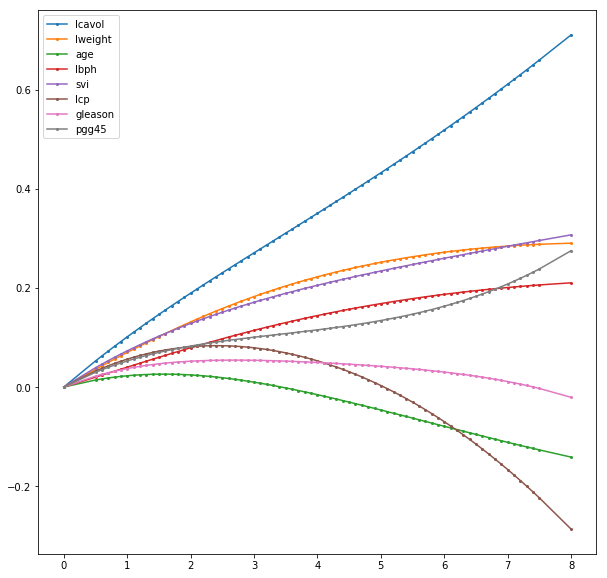

In [4]:
u, s, vh = scipy.linalg.svd(data_x_train_normalized, full_matrices=False)
s2 = s**2
edfs, lambdas = lambdas_from_edf(s2, 10)
# beta_ols = vh.T @ scipy.diag(scipy.reciprocal(s)) @ u.T @ vec_y
# print(beta_ols)
beta_ridge_array = [scipy.zeros(size_predictor)]
for lamb in lambdas:
    mat_diag = scipy.diag(s/(s2+lamb))
    beta_ridge = vh.T @ mat_diag @ u.T @ vec_y
    beta_ridge_array.append(beta_ridge)
beta_ridge_array = scipy.array(beta_ridge_array)

fig38 = plt.figure(figsize=(10, 10))
ax = fig38.add_subplot(1, 1, 1)
ax.plot(edfs, beta_ridge_array, 'o-', markersize=2)
ax.legend(data_x_train.columns)
plt.show()

### From the Bayesian point of view

Ridge regression can also be derived as the mean or mode of a posterior distribution, with a suitably chosen prior distribution.

Suppose

\begin{align}
y_i &\sim N(\beta_0+x_i^T\beta, \sigma^2) \\
\beta_j &\sim \text{ i.i.d. }N(0, \tau^2)
\end{align}

Then the log-posterior density of $\beta$, with $\tau^2$ and $\sigma^2$ assumed known, is equal to the expression

\begin{equation}
\sum_{i=1}^N\left( y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j \right)^2 +\frac{\sigma^2}{\tau^2}\sum_{j=1}^p \beta_j^2,
\end{equation}

which is the penalized residual sum of squares with $\lambda = \sigma^2/\tau^2$. Thus the ridge estimate is the mode of the posterior distribution; since the distribution is Gaussian, it is also the posterior mean.

### The singular value decomposition (SVD)

The SVD of the centered input matrix $\mathbf{X}$ gives us some additional insight into the nature of ridge regression. The SVD of the $N\times p$ matrix $\mathbf{X}$ has the form

\begin{equation}
\mathbf{X} = \mathbf{UDV}^T,
\end{equation}

where
* $\mathbf{U}$ is $N\times p$ orthogonal matrix, with the columns of $\mathbf{U}$ spanning the $\text{col}(\mathbf{X})$
* $\mathbf{V}$ is $p\times p$ orthogonal matrix, with the columns of $\mathbf{V}$ spanning the $\text{row}(\mathbf{X})$
* $\mathbf{D}$ is a $p\times p$ diagonal matrix, with diagonal entries  
$d_1 \ge d_2 \ge \cdots \ge d_p \ge 0$ called the singular values of $\mathbf{X}$.
* If one or more values $d_j = 0$, $\mathbf{X}$ is singular.

Using the SVD we can write the least squares fitted vector as

\begin{align}
\mathbf{X}\hat\beta^{\text{ls}} &= \mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} \\
&= \mathbf{UU}^T\mathbf{y}.
\end{align}

Note
* $\mathbf{U}^T\mathbf{y}$ are the coordinates of $\mathbf{y}$ w.r.t. the orthonormal basis $\mathbf{U}$.
* the similarity with QR decomposition; $\mathbf{Q}$ and $\mathbf{U}$ are generally different orthogonal bases for $\text{col}(\mathbf{X})$.

Now the ridge solutions are

\begin{align}
\mathbf{X}\hat\beta^{\text{ridge}} &= \mathbf{X}(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y} \\
&= \mathbf{UD}(\mathbf{D}^2 + \lambda\mathbf{I})^{-1}\mathbf{DU}^T\mathbf{y} \\
&= \sum_{j=1}^p \mathbf{u}_j \frac{d_j^2}{d_j^2+\lambda}\mathbf{u}_j^T\mathbf{y},
\end{align}

where the $\mathbf{u}_j$ are the columns of $\mathbf{U}$. The ridge solution then shrinks these coordinates by the factors $d_j^2/(d_j^2+\lambda)$. This means that a greater amount of shrinkage is applied to the coordinates of basis vectors with smaller $d_j^2$. Then what does a small value of $d_j^2$ mean?

### The SVD and the principal components

The SVD of the centered matrix $\mathbf{X}$ is another way of expressing the *principal components* of the variables in $\mathbf{X}$. The sample covariance matrix is given by

\begin{equation}
\mathbf{S} = \frac{1}{N}\mathbf{X}^T\mathbf{X},
\end{equation}

and via the SVD,

\begin{equation}
\mathbf{X}^T\mathbf{X} = \mathbf{VD}^2\mathbf{V}^T,
\end{equation}

which is the *eigen decomposition* of $\mathbf{X}^T\mathbf{X}$ (and of $\mathbf{S}$, up to a factor $N$). The eigenvectors $v_j$ (columns of $\mathbf{V}$) are also called the *principal components* (or Karhunen-Loeve) directions of $\mathbf{X}$. The first principal component direction $v_1$ has the property that $\mathbf{z}_1 = \mathbf{X}v_1$ has the larger sample projected variance than any other direction. This sample variance is easily seen to be

\begin{equation}
\text{Var}(\mathbf{z}_1) = \text{Var}(\mathbf{X}v_1) = \frac{d_1^2}{N},
\end{equation}

and in fact $\mathbf{z}_1 = \mathbf{X}v_1 = \mathbf{u}_1 d_1$. The derived variable $z_1$ is called the first principal component of $\mathbf{X}$, and hence $\mathbf{u}_1$ is the normalized first principal component. And subsequent principal components $z_j$ have maximum variance $d_j^2/N$, subject to being orthogonal to the earlier ones. Conversely the last principal component has minimum variance. Hence the small singular values $d_j$ correspond to directions in the $\text{col}(\mathbf{X})$ having small variance, and ridge regression shrinks these directions the most. In simple words, it does not care what seems not worth. See FIGURE 3.9 for the graphical representation of the principal components.

Ridge regression protects against the potentially high variance of gradients estimated in the short directions.

### The effective degrees of freedom

In FIGURE 3.7 we have plotted the estimated prediction error versus the quantity

\begin{align}
\text{df}(\lambda) &= \text{tr}\left( \mathbf{X}(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T \right), \\
&= \text{tr}(\mathbf{H}_\lambda) \\
&= \sum_{j=1}^p \frac{d_j^2}{d_j^2+\lambda}.
\end{align}

This monotone decreasing function of $\lambda$ is the *effective degrees of freedom* of the ridge regression fit. Usually in a linear-regression fit, the degrees-of-freedom of the fit is $p$, the number of free parameters. The idea is that although all $p$ coefficients in a ridge fit will be non-zero, they are fit in a restricted fashion controlled by $\lambda$. Note that

\begin{align}
\text{df}(\lambda) &= p \text{ when }\lambda = 0, \\
\text{df}(\lambda) &\rightarrow 0 \text{ as }\lambda \rightarrow \infty.
\end{align}

Of course there is always an additional one degree of freedom for the intercept, which was removed *apriori*. This definition is motivated in more detail in Section 3.4.4 and Sections 7.4-7.6.

In [5]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
"""FIGURE 3.7. CV result of the ridge regression"""
import collections
import math

from module import cv

cv10_indices = cv.index_tenfold(size_train)
cv_beta = collections.defaultdict(list)
cv_rss = collections.defaultdict(list)

for cv_idx in range(10):
    mask_cv = cv10_indices != cv_idx
    size_cv_train = (mask_cv == True).size
    df_x = data_x_train_normalized[mask_cv]
    cv_x = df_x.as_matrix()
    v_y = vec_y[mask_cv]

    # Exceptional case for lambda = infinity, or edf = 0 (constant model)
    v_y_mean= v_y.mean()
    cv_rss[0].append(((v_y-v_y_mean)**2).sum()/size_cv_train)
    
    u, s, vh = scipy.linalg.svd(cv_x, full_matrices=False)
    s2 = s**2
    edfs, lambdas = lambdas_from_edf(s2, 2)

    for edf, lamb in zip(edfs[1:], lambdas):
        mat_diag = scipy.diag(s/(s2+lamb))
        beta_ridge = vh.T @ mat_diag @ u.T @ v_y
        cv_beta[edf].append(beta_ridge)
        cv_y_fitted = cv_x @ beta_ridge
        cv_rss[edf].append(((v_y-cv_y_fitted)**2).sum()/size_cv_train)

cv_rss_average = [sum(rss)/len(rss) for _, rss in cv_rss.items()]
cv_rss_stderr = [math.sqrt(((scipy.array(rss)**2).sum()-sum(rss)**2/10)/9)
                 for _, rss in cv_rss.items()]

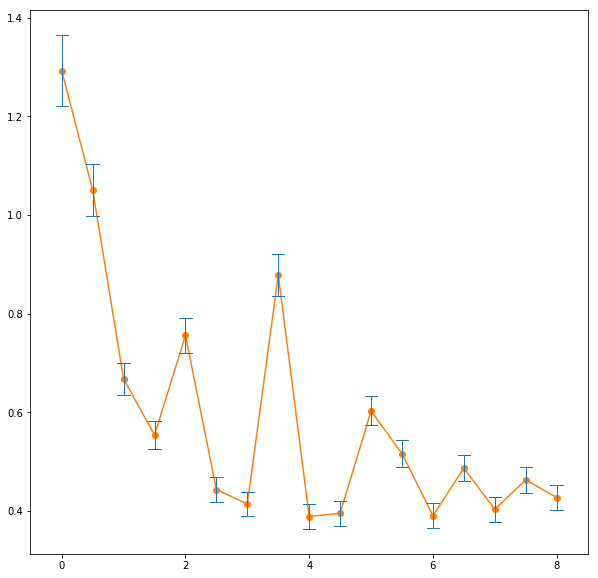

In [7]:
fig27 = plt.figure(figsize=(10, 10))
ax = fig27.add_subplot(1, 1, 1)
ax.plot(edfs, cv_rss_average, 'o-', color='C1')
for k, (ave, stderr) in enumerate(zip(cv_rss_average, cv_rss_stderr)):
    ax.plot([k/2, k/2], [ave-stderr, ave+stderr], color='C0', linewidth=1)
    ax.plot([k/2-.1, k/2+.1], [ave-stderr, ave-stderr],
            color='C0', linewidth=1)
    ax.plot([k/2-.1, k/2+.1], [ave+stderr, ave+stderr],
            color='C0', linewidth=1)
plt.show()

In [8]:
"""Table 3.3. for the ridge regression

Use lambda = 5 as the textbook does, even though the previous CV results
do not agree with.

Please note that this table does not exactly reproduce the output from the
textbook.
"""
lambda_from_cv = lambdas[scipy.where(edfs == 5)[0]-1]  # lambda with edf = 5

u, s, vh = scipy.linalg.svd(data_x_train_normalized, full_matrices=False)
s2 = s**2

mat_diag = scipy.diag(s/(s2+lambda_from_cv))
beta_ridge = vh.T @ mat_diag @ u.T @ vec_y

mat_x_test = data_x_test_normalized.as_matrix()
vec_y_test_fitted = mat_x_test @ beta_ridge

print('{0:>15} {1:>15}'.format('Term', 'Best Subset'))
print('-'*31)
print('{0:>15} {1:>15.3f}'.format('Intercept', beta_intercept))
for idx, col_name in enumerate(data.columns):
    print('{0:>15} {1:>15.3f}'.format(col_name, beta_ridge[idx]))
print('-'*31)
print('{0:>15} {1:>15.3f}'.format(
    'Test Error',
    ((vec_y_test-vec_y_test_fitted-beta_intercept)**2).sum()/size_test),
)

           Term     Best Subset
-------------------------------
      Intercept           2.452
         lcavol           0.451
        lweight           0.257
            age          -0.053
           lbph           0.173
            svi           0.240
            lcp          -0.011
        gleason           0.040
          pgg45           0.140
-------------------------------
     Test Error           0.503
